# Imports

In [1]:
import pandas as pd
import geopandas as gpd

import geoplot as gplt

import matplotlib.pyplot as plt

import mapclassify as mc

from helper_scripts import utils

#recommended figsize
figsize = (30,15)

# Load data

In [2]:
# Load districtwise map data
map_data = gpd.read_file('../data/nepal_map_data/nepal-districts.geojson')

# Load number of enrollments and teachers data
raw_enrollments_primary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Enrollment/total-enrollment-in-primary-school-districtwise.csv')
raw_enrollments_lower_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Enrollment/total-enrollment-in-lower-secondary-districtwise.csv')
raw_enrollments_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Enrollment/total-enrollment-in-secondary-districtwise.csv')

raw_teachers_primary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Teachers/primary-teachers-districtwise.csv')
raw_teachers_lower_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Teachers/lower-secondary-teachers-districtwise.csv')
raw_teachers_secondary = pd.read_csv('../data/OpenDataNepal/NepalCBS/Education/Teachers/secondary-school-teachers-districtwise.csv')

# Preprocess

In [3]:
# rename columns and remove unnecessary aggregate row
# we only need the year and district data
year = '2015'

enrollments_primary = raw_enrollments_primary[['District', year]].rename(columns={'District':'DISTRICT', year:'Enrollments'})[:-1]
teachers_primary = raw_teachers_primary[['Region/District', year]].rename(columns={'Region/District':'DISTRICT', year:'Teachers'})[:-1]

# calculate the composite measure in a new frame, and add it to the geo data
prelem_ratio_dataframe = pd.merge(enrollments_primary, teachers_primary, how='inner', on='DISTRICT')
prelem_ratio_dataframe['ratio'] = round(prelem_ratio_dataframe['Enrollments']/prelem_ratio_dataframe['Teachers'], 2)

# match the cases and merge with the map data
prelem_ratio_dataframe['DISTRICT'] = prelem_ratio_dataframe['DISTRICT'].str.upper()

final_ratio_data = map_data.merge(prelem_ratio_dataframe, how='inner', on='DISTRICT')

In [4]:
# Handling small districts and the values needed for their labelling

small_districts = ('PARBAT','ARGHAKHANCHI', 'KATHMANDU', 'BHAKTAPUR', 'LALITPUR','RAUTAHAT',
                            'MAHOTTARI', 'DHANUSHA', 'DHANKUTA', 'TEHRATHUM', 'PANCHTHAR')

small_districts_label_dict = {}
small_districts_legends = []

for (district, ratio) in final_ratio_data[['DISTRICT','ratio']].to_records(index=False):   
    if district in small_districts:     
        ann_number = small_districts.index(district)

        # converting the number to a representation of captial text i.e. 1->A, 2->B, etc.
        text = f'{chr(ann_number+97).upper()}.'

        small_districts_label_dict[district] = text
        small_districts_legends.append(f'{text[:-1].center(5)} -  {district.title().ljust(15)}: {str(ratio).ljust(5)} ')

# PLOT IN A MAP!

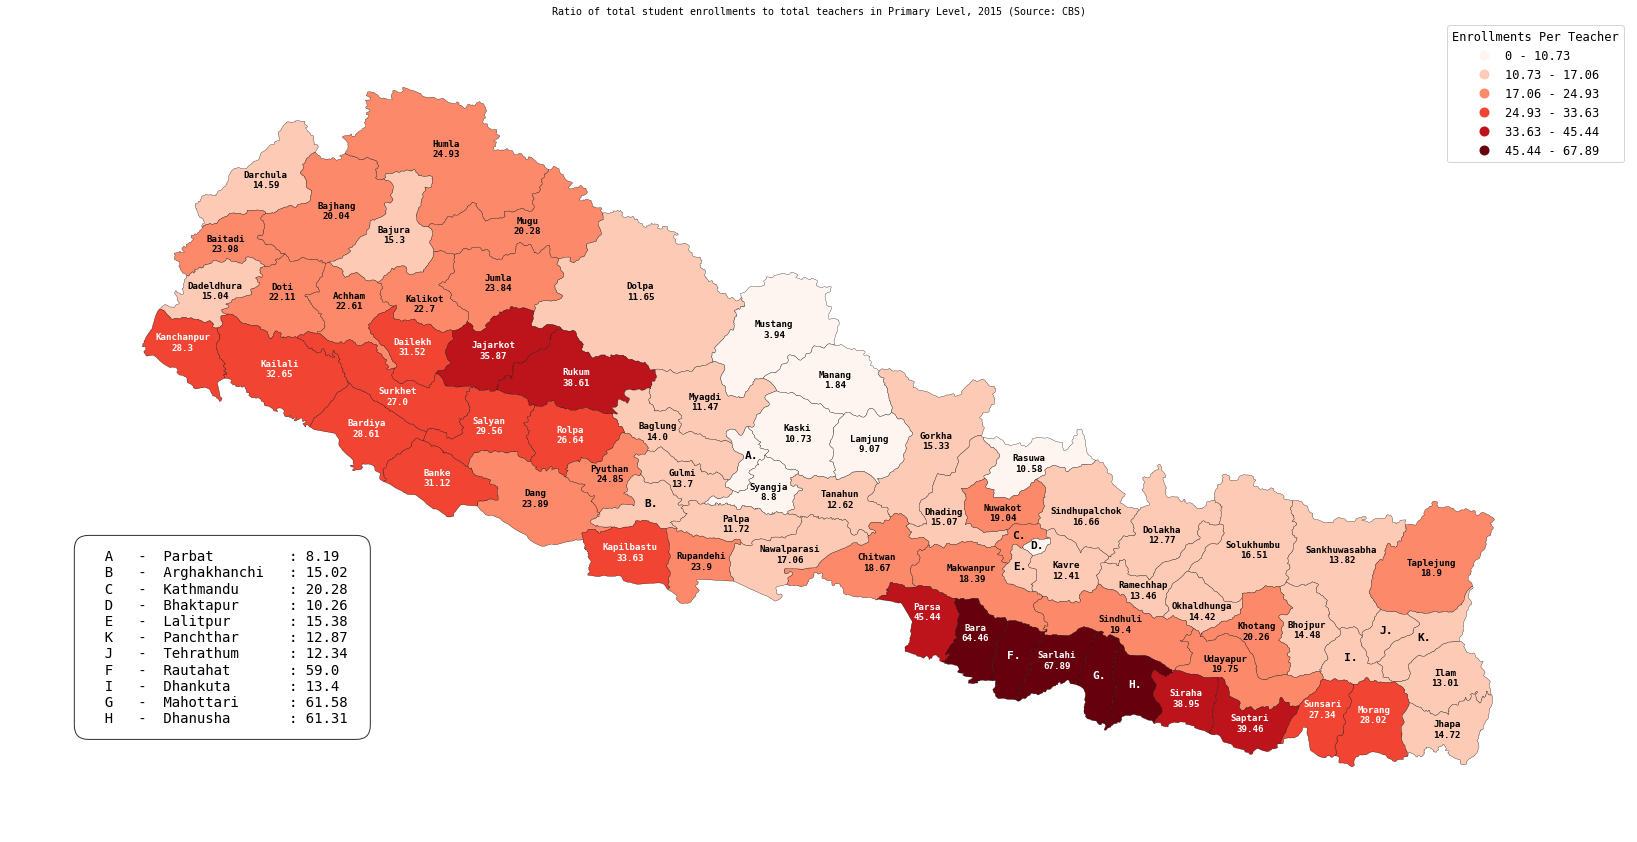

In [5]:
scheme = mc.FisherJenks(final_ratio_data['ratio'], k=6)

plt.rcParams['font.family'] = 'monospace'
# currently does not work well for other non default projections like gcrs.AlbersEqualArea()
ax = gplt.choropleth(
    final_ratio_data, figsize=figsize,
    hue='ratio',
    cmap='Reds', linewidth=0.3, 
    legend_kwargs={"loc":"best",
                    "fontsize": "large",
                    "title":"Enrollments Per Teacher",
                    "title_fontsize":"large"},
    legend=True, scheme=scheme
)

# apply annotation to every district so they appear on map
annotation_args = {
    'annotation_field' : 'DISTRICT',
    'annotation_value_field' : 'ratio',
    'small_polygon_map' : small_districts_label_dict,
    'threshold' :24.94
}

final_ratio_data.apply(utils.annotate_polygons(ax, **annotation_args), axis=1)

small_districts_legends_str = '\n'.join(small_districts_legends)
props = dict(boxstyle='round', facecolor='white', alpha=0.8, pad = 1)

# place a text box for small district legend
ax.text(0.05, 0.35, small_districts_legends_str, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title("Ratio of total student enrollments to total teachers in Primary Level, 2015 (Source: CBS)", fontdict={"fontsize": 10}, pad=5)
plt.savefig('../visualizations/PrimaryStudentTeacher.svg', bbox_inches='tight')